<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.0.0

    100% |████████████████████████████████| 532.5MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5f974000 @  0x7f0d898ab2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 6.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 153kB 4.7MB/s 
    100% |████████████████████████████████| 112kB 4.6MB/s 
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ |

In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

手書き文字認識のMNISTを例題として，確率的勾配降下法を作成する．

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

フォルダを準備し，データをダウンロードして，所定フォルダに移動させてから，展開する．

In [0]:
!mkdir data

In [0]:
!mkdir data/mnist

In [0]:
path = Path('data/mnist')

In [11]:
path.ls()

[]

In [15]:
!wget  http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-01-08 03:47:24--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  17.2MB/s    in 0.9s    

2019-01-08 03:47:25 (17.2 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
!mv mnist.pkl.gz data/mnist

圧縮ファイルを展開して，pickleファイルから訓練データと検証データを得る．

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

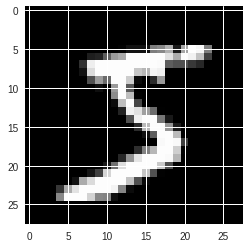

In [18]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [26]:
28*28

784

ロードしたデータはNumPyの配列であるので，それをPyTorchのテンソルに変換する．

訓練データの型（shape；行数と列数）から，データ数nとクラス数cを得る．

In [20]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

以前は自分で降下法を記述したが，ここではPyTorchの関数を用いてミニバッチを扱ってみよう．

bsはバッチサイズで今回は64に設定する．

訓練(検証)データからデータセットのインスタンスtrain_ds(valid_ds)を生成する．

**（PyTorchのデータセット = 独立変数のデータ，従属変数のデータ）**

fastaiのDataBunch（データ束）インスタンスを訓練データセットと検証データセットとバッチサイズから生成する．

** (fastaiのデータ束 =訓練データセット, 検証データセット, バッチサイズ )**

これによって，データがバッチごとに生成することができる．


In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)#バッチサイズは64

データ束インスタンスdataのtrain_dlは訓練データのデータローダである．これで次のデータの組を生成すると，64行（バッチサイズ），784列（28*28：画像データのサイズ）のxと，正解を表す数字の入った64行のデータであることが確認できる．

In [63]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

PyTorchのニューラルネットクラス nn.Moduleから派生させてMnist_Logisticクラスを作る．

コンストラクタでは，線形層 Linearだけを定義する．これは， 入力の784の長さのテンソルを，長さ10のテンソルに変換する．

関数forwardは，与えられたテンソルxbを，コンストラクタで定義した線形層 self.lin に入れて返す．

PyTorchでは，このようにコンストラクタでアーキテクチャ（モデル）を定義し，実際の計算はforward関数で定義する．

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic()

In [66]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [32]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

xは64行（バッチサイズ），784列であるので，これをモデルに入れると1バッチ分の予測 (64*10)の型のテンソルが返される．

In [35]:
model(x).shape

torch.Size([64, 10])

In [36]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss() #損出関数を定義(多クラスなので交差エントロピーを用いる．)

In [0]:
def update(x,y,lr):
    wd = 1e-5 #重み減衰パラメータ
    y_hat = model(x) #ニューラルネットを前方計算し，yhatを求める
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward() #逆伝播で勾配を計算する
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

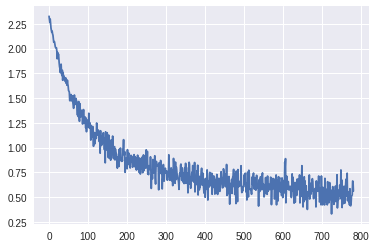

In [71]:
plt.plot(losses);

隠れ層（50個のニューロン）を追加してみる．

第1層lin1で線形変換をした後に，reluの活性化関数を入れる．これは負のものを0に変換するだけである．

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

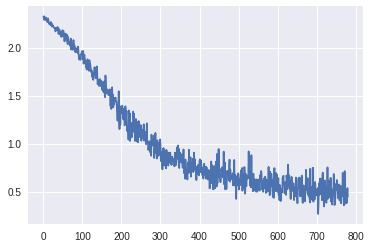

In [58]:
plt.plot(losses);

今度はモデルは同じだが，最適化にPyTorchの組み込みであるAdamを用いてみる．

(通常の確率的勾配降下法とくらべて，ちょっと良くなっていることが確認できる．）

In [0]:
model = Mnist_NN()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

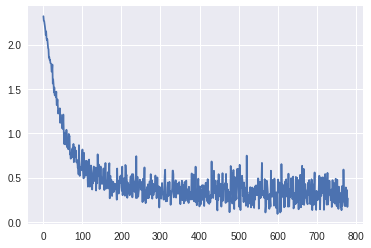

In [75]:
plt.plot(losses);

最後に，fastaiの学習器クラスLearnerを用いて訓練してみる．

学習器クラスへの入力は，データ束，モデル（アーキテクチャ），損出関数，メトリクス（評価尺度）である．

fastaiのプロットは，指数平滑法で平滑化してあるので，ギザギザしていない．損出関数もだいぶ良いことに注目せよ．

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


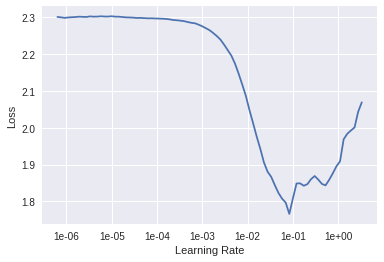

In [77]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.140788,0.132161,0.963000


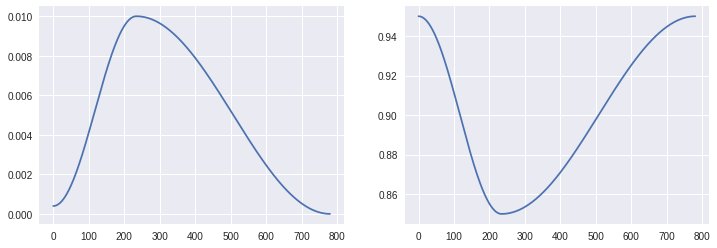

In [80]:
learn.recorder.plot_lr(show_moms=True)

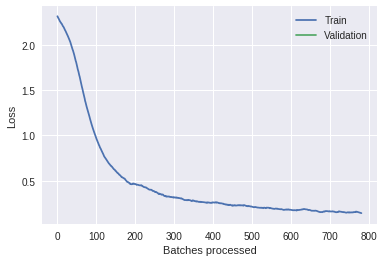

In [84]:
learn.recorder.plot_losses()

## fin